In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA

%matplotlib inline

# 1. Data Processing

In [2]:
#pip install --upgrade category_encoders

In [3]:
import category_encoders as ce

df_origin = pd.read_csv("sample_01_v2.csv")
#test_origin = pd.read_csv("test.txt", sep=",")
#test = test_origin.copy()
df = df_origin.copy()

df.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18_2,C19,C20,C21
count,3.756300e+05,375630.00000,3.756300e+05,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000,375630.000000
mean,9.228584e+18,0.17957,1.410255e+07,1004.966930,0.305245,1.016261,0.232628,18640.558291,318.778191,60.689838,2086.223137,0.378234,229.937279,51375.962287,82.221990
std,5.328134e+18,0.38383,3.000877e+02,1.130853,0.514803,0.543027,0.700137,5065.332557,21.439113,48.373919,621.330650,0.783204,362.439628,50036.346650,70.953744
min,3.358329e+13,0.00000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,4.610049e+18,0.00000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16615.000000,320.000000,50.000000,1800.000000,0.000000,35.000000,-1.000000,23.000000
50%,9.238227e+18,0.00000,1.410252e+07,1005.000000,0.000000,1.000000,0.000000,20108.000000,320.000000,50.000000,2291.000000,0.000000,39.000000,100013.000000,52.000000
75%,1.384659e+19,0.00000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21889.000000,320.000000,50.000000,2526.000000,0.000000,175.000000,100084.000000,110.000000
max,1.844672e+19,1.00000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24044.000000,1024.000000,1024.000000,2757.000000,2.000000,1839.000000,100248.000000,255.000000


1    344794
0     21907
4      7701
5      1228
Name: device_type, dtype: int64

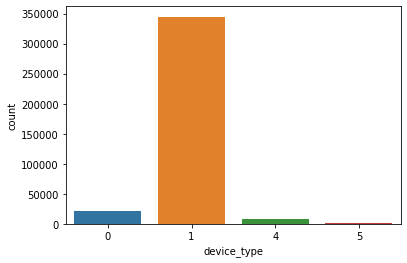

In [4]:
data = pd.concat([df['click'],df['device_type']],axis=1)
sns.countplot(x='device_type',data=data)
data.loc[:,'device_type'].value_counts()

In [5]:
device_type_table = pd.crosstab(index=df['device_type'],columns=df['click'])
device_type_table

click,0,1
device_type,,
0,17416,4491
1,282713,62081
4,6934,767
5,1115,113


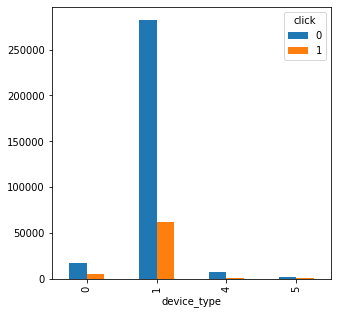

In [6]:
device_type_table.plot(kind='bar',figsize=(5,5),stacked=False)

In [7]:
def processHour(value):
    value = str(value)
    new_value = value[6:]
    return new_value

#change hour to real hour:
df['hour'] = df['hour'].apply(processHour)

df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18_2,C19,C20,C21
0,6.616796e+17,0,14,1002,0,00255fb4,14455441,50e219e0,ecad2386,7801e8d9,07d7df22,75f49163,8c157465,167219a5,0,0,22290,320,50,2573,0,419,-1,178
1,5.786661e+18,1,21,1002,0,00255fb4,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,174d0aff,3078e351,54db068e,0,0,6563,320,50,572,2,39,-1,32
2,7.129294e+17,0,12,1002,0,00255fb4,240a9324,50e219e0,ecad2386,7801e8d9,07d7df22,d2caeb99,ba514e47,12edfe21,0,0,23206,320,50,2672,0,35,-1,221
3,1.402953e+19,0,05,1002,0,00255fb4,240a9324,50e219e0,ecad2386,7801e8d9,07d7df22,30708645,73d76ea2,6f856677,0,0,22700,320,50,2624,0,35,100075,221
4,1.715114e+19,0,09,1002,0,00255fb4,240a9324,50e219e0,ecad2386,7801e8d9,07d7df22,4ce85f9b,36f2f49d,4042e175,0,0,22700,320,50,2624,0,35,100079,221


In [8]:
columns = {'site_id', 'site_domain','site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type'}

for col in columns:
    df[col] = df[col].astype('category')

encoder = ce.BinaryEncoder(cols = columns)

df_binary= encoder.fit_transform(df)

df_binary.head()

,id,click,hour,C1,banner_pos,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_domain_0,site_domain_1,site_domain_2,site_domain_3,site_domain_4,site_domain_5,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_domain_10,site_domain_11,site_domain_12,site_category_0,site_category_1,site_category_2,site_category_3,site_category_4,site_category_5,app_id_0,app_id_1,app_id_2,app_id_3,app_id_4,app_id_5,app_id_6,app_id_7,app_id_8,app_id_9,app_id_10,app_id_11,app_id_12,app_domain_0,app_domain_1,app_domain_2,app_domain_3,app_domain_4,app_domain_5,app_domain_6,app_domain_7,app_domain_8,app_category_0,app_category_1,app_category_2,app_category_3,app_category_4,app_category_5,device_id_0,device_id_1,device_id_2,device_id_3,device_id_4,device_id_5,device_id_6,device_id_7,device_id_8,device_id_9,device_id_10,device_id_11,device_id_12,device_id_13,device_id_14,device_id_15,device_id_16,device_ip_0,device_ip_1,device_ip_2,device_ip_3,device_ip_4,device_ip_5,device_ip_6,device_ip_7,device_ip_8,device_ip_9,device_ip_10,device_ip_11,device_ip_12,device_ip_13,device_ip_14,device_ip_15,device_ip_16,device_ip_17,device_ip_18,device_model_0,device_model_1,device_model_2,device_model_3,device_model_4,device_model_5,device_model_6,device_model_7,device_model_8,device_model_9,device_model_10,device_model_11,device_model_12,device_model_13,device_type_0,device_type_1,device_type_2,device_conn_type_0,device_conn_type_1,device_conn_type_2,C14,C15,C16,C17,C18_2,C19,C20,C21
0,6.616796e+17,0,14,1002,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,1,22290,320,50,2573,0,419,-1,178
1,5.786661e+18,1,21,1002,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,0,0,1,0,1,1,0,0,1,1,1,0,1,0,0,1,0,0,1,6563,320,50,572,2,39,-1,32
2,7.129294e+17,0,12,1002,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,1,0,0,1,23206,320,50,2672,0,35,-1,221
3,1.402953e+19,0,05,1002,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,22700,320,50,2624,0,35,100075,221
4,1.715114e+19,0,09,1002,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,22700,320,50,2624,0,35,100079,221


In [9]:
X = df_binary.iloc[:,2:]
Y = df_binary['click']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [10]:
print(df_binary.shape)

print(X.shape)
print(X_train.shape)
print(X_test.shape)

print(Y.shape)
print(Y_train.shape)
print(Y_test.shape)

(375630, 129)
(375630, 127)
(300504, 127)
(75126, 127)
(375630,)
(300504,)
(75126,)


In [11]:
columns_orig = X.columns
columns_orig

Index(['hour', 'C1', 'banner_pos', 'site_id_0', 'site_id_1', 'site_id_2',
       'site_id_3', 'site_id_4', 'site_id_5', 'site_id_6',
       ...
       'device_conn_type_1', 'device_conn_type_2', 'C14', 'C15', 'C16', 'C17',
       'C18_2', 'C19', 'C20', 'C21'],
      dtype='object', length=127)

In [12]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = pd.DataFrame(scaling.transform(X_train))
X_test = pd.DataFrame(scaling.transform(X_test))

In [13]:
X_train.columns = X.columns
X_test.columns = X.columns

In [14]:
X_train.head()

,hour,C1,banner_pos,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_domain_0,site_domain_1,site_domain_2,site_domain_3,site_domain_4,site_domain_5,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_domain_10,site_domain_11,site_domain_12,site_category_0,site_category_1,site_category_2,site_category_3,site_category_4,site_category_5,app_id_0,app_id_1,app_id_2,app_id_3,app_id_4,app_id_5,app_id_6,app_id_7,app_id_8,app_id_9,app_id_10,app_id_11,app_id_12,app_domain_0,app_domain_1,app_domain_2,app_domain_3,app_domain_4,app_domain_5,app_domain_6,app_domain_7,app_domain_8,app_category_0,app_category_1,app_category_2,app_category_3,app_category_4,app_category_5,device_id_0,device_id_1,device_id_2,device_id_3,device_id_4,device_id_5,device_id_6,device_id_7,device_id_8,device_id_9,device_id_10,device_id_11,device_id_12,device_id_13,device_id_14,device_id_15,device_id_16,device_ip_0,device_ip_1,device_ip_2,device_ip_3,device_ip_4,device_ip_5,device_ip_6,device_ip_7,device_ip_8,device_ip_9,device_ip_10,device_ip_11,device_ip_12,device_ip_13,device_ip_14,device_ip_15,device_ip_16,device_ip_17,device_ip_18,device_model_0,device_model_1,device_model_2,device_model_3,device_model_4,device_model_5,device_model_6,device_model_7,device_model_8,device_model_9,device_model_10,device_model_11,device_model_12,device_model_13,device_type_0,device_type_1,device_type_2,device_conn_type_0,device_conn_type_1,device_conn_type_2,C14,C15,C16,C17,C18_2,C19,C20,C21
0,0.478261,-0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.884406,-0.557522,-0.940239,0.893384,-1.0,-0.997785,-1.000000,-0.606299
1,-0.652174,-0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.806920,-0.557522,-0.940239,0.807183,-1.0,-0.997785,-1.000000,0.732283
2,0.739130,-0.272727,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.666146,-0.601770,-0.541833,0.650662,1.0,-0.997785,0.996588,-0.826772
3,0.913043,-0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1

In [15]:
X_test.describe()

,hour,C1,banner_pos,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_domain_0,site_domain_1,site_domain_2,site_domain_3,site_domain_4,site_domain_5,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_domain_10,site_domain_11,site_domain_12,site_category_0,site_category_1,site_category_2,site_category_3,site_category_4,site_category_5,app_id_0,app_id_1,app_id_2,app_id_3,app_id_4,app_id_5,app_id_6,app_id_7,app_id_8,app_id_9,app_id_10,app_id_11,app_id_12,app_domain_0,app_domain_1,app_domain_2,app_domain_3,app_domain_4,app_domain_5,app_domain_6,app_domain_7,app_domain_8,app_category_0,app_category_1,app_category_2,app_category_3,app_category_4,app_category_5,device_id_0,device_id_1,device_id_2,device_id_3,device_id_4,device_id_5,device_id_6,device_id_7,device_id_8,device_id_9,device_id_10,device_id_11,device_id_12,device_id_13,device_id_14,device_id_15,device_id_16,device_ip_0,device_ip_1,device_ip_2,device_ip_3,device_ip_4,device_ip_5,device_ip_6,device_ip_7,device_ip_8,device_ip_9,device_ip_10,device_ip_11,device_ip_12,device_ip_13,device_ip_14,device_ip_15,device_ip_16,device_ip_17,device_ip_18,device_model_0,device_model_1,device_model_2,device_model_3,device_model_4,device_model_5,device_model_6,device_model_7,device_model_8,device_model_9,device_model_10,device_model_11,device_model_12,device_model_13,device_type_0,device_type_1,device_type_2,device_conn_type_0,device_conn_type_1,device_conn_type_2,C14,C15,C16,C17,C18_2,C19,C20,C21
count,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.00000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.0,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000,75126.000000
mean,-0.031568,-0.278282,-0.912874,-1.0,-0.973511,0.198786,-0.331283,-0.025371,-0.738945,0.180710,-0.718553,0.315390,0.407928,-0.523174,-0.573863,0.152970,-1.0,-0.638607,0.221042,0.073903,-0.568485,0.108298,-0.569071,-0.397572,-0.698879,0.605649,-0.405985,0.428214,0.497484,-1.0,-0.323856,-0.985757,0.586002,0.156617,-0.974576,-1.0,-0.918883,0.660224,0.692596,0.727232,0.723212,0.601523,0.558688,0.719831,-0.659612,-0.691265,0.696483,-0.748795,-1.0,-0.987807,0.593589,-0.794053,-0.611320,-0.830711,-0.560072,0.615047,0.636690,-1.0,-0.782898,-0.935495,-0.507627,-0.985385,0.449299,-1.0,0.812848,-0.828794,0.814312,-0.828874,-0.821633,-0.822458,0.819051,0.821580,-0.823044,-0.821473,-0.823204,-0.81953,0.819956,0.822751,0.819370,-0.822352,-1.0,-0.049756,-0.062215,-0.057211,-0.061177,-0.025610,0.003940,0.003860,-0.005165,-0.012273,-0.

In [16]:
train = X_train.copy()
train['click'] = Y_train.values

In [17]:
train.head()

,hour,C1,banner_pos,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_domain_0,site_domain_1,site_domain_2,site_domain_3,site_domain_4,site_domain_5,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_domain_10,site_domain_11,site_domain_12,site_category_0,site_category_1,site_category_2,site_category_3,site_category_4,site_category_5,app_id_0,app_id_1,app_id_2,app_id_3,app_id_4,app_id_5,app_id_6,app_id_7,app_id_8,app_id_9,app_id_10,app_id_11,app_id_12,app_domain_0,app_domain_1,app_domain_2,app_domain_3,app_domain_4,app_domain_5,app_domain_6,app_domain_7,app_domain_8,app_category_0,app_category_1,app_category_2,app_category_3,app_category_4,app_category_5,device_id_0,device_id_1,device_id_2,device_id_3,device_id_4,device_id_5,device_id_6,device_id_7,device_id_8,device_id_9,device_id_10,device_id_11,device_id_12,device_id_13,device_id_14,device_id_15,device_id_16,device_ip_0,device_ip_1,device_ip_2,device_ip_3,device_ip_4,device_ip_5,device_ip_6,device_ip_7,device_ip_8,device_ip_9,device_ip_10,device_ip_11,device_ip_12,device_ip_13,device_ip_14,device_ip_15,device_ip_16,device_ip_17,device_ip_18,device_model_0,device_model_1,device_model_2,device_model_3,device_model_4,device_model_5,device_model_6,device_model_7,device_model_8,device_model_9,device_model_10,device_model_11,device_model_12,device_model_13,device_type_0,device_type_1,device_type_2,device_conn_type_0,device_conn_type_1,device_conn_type_2,C14,C15,C16,C17,C18_2,C19,C20,C21,click
0,0.478261,-0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.884406,-0.557522,-0.940239,0.893384,-1.0,-0.997785,-1.000000,-0.606299,0
1,-0.652174,-0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.806920,-0.557522,-0.940239,0.807183,-1.0,-0.997785,-1.000000,0.732283,0
2,0.739130,-0.272727,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.666146,-0.601770,-0.541833,0.650662,1.0,-0.997785,0.996588,-0.826772,0
3,0.913043,-0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0

In [18]:
# create csv file for R

train.to_csv('training.csv', index=False)

                                
######################################
##                                  ##
##  ##############################  ##
##  ### feature selection in R ###  ##
##  ##############################  ##
##                                  ##
######################################

In [19]:
# select useful features based on R results
# data will be used for FPCA transformation

fpca_train = X_train[[
    "app_category_1", "app_category_2", "app_category_3", "app_domain_1", "app_domain_3",
    "app_domain_5", "app_domain_6", "app_id_1", "app_id_12", "app_id_2",
    "app_id_3", "app_id_4", "app_id_8", "banner_pos", "hour",
    "C14", "C15", "C16", "C19", "C20",
    "C21", "device_conn_type_0", "device_conn_type_1", "device_model_12", "device_model_2",
    "device_model_3", "device_model_6", "device_model_8", "site_category_1", "site_category_2",
    "site_category_3", "site_category_5", "site_domain_1", "site_domain_10", "site_domain_12",
    "site_domain_3", "site_domain_4", "site_domain_6", "site_domain_7", "site_domain_8",
    "site_domain_9", "site_id_10", "site_id_11", "site_id_12", "site_id_2",
    "site_id_3", "site_id_4", "site_id_6", "site_id_7", "site_id_8",
]]

In [20]:
fpca_train['click'] = Y_train.values

fpca_train['C18_2'] = X_train['C18_2'].values
#fpca_train.loc[fpca_train.C18_2 < 1, 'C18_2'] = 0
fpca_train = fpca_train.astype({'C18_2': 'int64'}) # !!! ensure sensitive attribute is set to int

/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
fpca_train.head()

,app_category_1,app_category_2,app_category_3,app_domain_1,app_domain_3,app_domain_5,app_domain_6,app_id_1,app_id_12,app_id_2,app_id_3,app_id_4,app_id_8,banner_pos,hour,C14,C15,C16,C19,C20,C21,device_conn_type_0,device_conn_type_1,device_model_12,device_model_2,device_model_3,device_model_6,device_model_8,site_category_1,site_category_2,site_category_3,site_category_5,site_domain_1,site_domain_10,site_domain_12,site_domain_3,site_domain_4,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_id_10,site_id_11,site_id_12,site_id_2,site_id_3,site_id_4,site_id_6,site_id_7,site_id_8,click,C18_2
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,0.478261,0.884406,-0.557522,-0.940239,-0.997785,-1.000000,-0.606299,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0,-1
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-0.652174,0.806920,-0.557522,-0.940239,-0.997785,-1.000000,0.732283,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0,-1
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,0.739130,0.666146,-0.601770,-0.541833,-0.997785,0.996588,-0.826772,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0,1
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,0.913043,0.689214,-0.557522,-0.940239,-0.993355,-1.000000,0.228346,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,0,-1
4,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,0.304348,-0.993494,-0.557522,-0.940239,0.433001,0.996489,-0.889764,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,0,-1


In [22]:
# sample 2% for FPCA algorithm

fpca_train_dev, dummy = train_test_split(fpca_train, test_size=0.98, random_state=10)

In [23]:
fpca_train_dev.shape

(6010, 52)

In [24]:
fpca_train_dev.to_csv('fpca_train_dev.csv', index=False)

############################################
##                                        ##
##  Use this .csv to run FPCA problem.py  ##
##                                        ##
############################################

In [25]:
#######################################
##                                   ##
##  Final Training and Testing sets  ##
##          Baseline Models          ##
##                                   ##
#######################################

X_train = X_train[[
    "app_category_1", "app_category_2", "app_category_3", "app_domain_1", "app_domain_3",
    "app_domain_5", "app_domain_6", "app_id_1", "app_id_12", "app_id_2",
    "app_id_3", "app_id_4", "app_id_8", "banner_pos", "hour",
    "C14", "C15", "C16", "C19", "C20",
    "C21", "device_conn_type_0", "device_conn_type_1", "device_model_12", "device_model_2",
    "device_model_3", "device_model_6", "device_model_8", "site_category_1", "site_category_2",
    "site_category_3", "site_category_5", "site_domain_1", "site_domain_10", "site_domain_12",
    "site_domain_3", "site_domain_4", "site_domain_6", "site_domain_7", "site_domain_8",
    "site_domain_9", "site_id_10", "site_id_11", "site_id_12", "site_id_2",
    "site_id_3", "site_id_4", "site_id_6", "site_id_7", "site_id_8",
    "C18_2"
]]

X_test = X_test[[
    "app_category_1", "app_category_2", "app_category_3", "app_domain_1", "app_domain_3",
    "app_domain_5", "app_domain_6", "app_id_1", "app_id_12", "app_id_2",
    "app_id_3", "app_id_4", "app_id_8", "banner_pos", "hour",
    "C14", "C15", "C16", "C19", "C20",
    "C21", "device_conn_type_0", "device_conn_type_1", "device_model_12", "device_model_2",
    "device_model_3", "device_model_6", "device_model_8", "site_category_1", "site_category_2",
    "site_category_3", "site_category_5", "site_domain_1", "site_domain_10", "site_domain_12",
    "site_domain_3", "site_domain_4", "site_domain_6", "site_domain_7", "site_domain_8",
    "site_domain_9", "site_id_10", "site_id_11", "site_id_12", "site_id_2",
    "site_id_3", "site_id_4", "site_id_6", "site_id_7", "site_id_8",
    "C18_2"
]]

In [26]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(300504, 51)
(300504,)
(75126, 51)
(75126,)


In [27]:
#######################################
##                                   ##
##  Final Training and Testing sets  ##
##            FPCA Models            ##
##                                   ##
#######################################

X_train_fpca = X_train.iloc[:,:X_train.shape[1]-1]
X_train_fpca.head()
X_test_fpca = X_test.iloc[:,:X_test.shape[1]-1]
X_test_fpca.head()

,app_category_1,app_category_2,app_category_3,app_domain_1,app_domain_3,app_domain_5,app_domain_6,app_id_1,app_id_12,app_id_2,app_id_3,app_id_4,app_id_8,banner_pos,hour,C14,C15,C16,C19,C20,C21,device_conn_type_0,device_conn_type_1,device_model_12,device_model_2,device_model_3,device_model_6,device_model_8,site_category_1,site_category_2,site_category_3,site_category_5,site_domain_1,site_domain_10,site_domain_12,site_domain_3,site_domain_4,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_id_10,site_id_11,site_id_12,site_id_2,site_id_3,site_id_4,site_id_6,site_id_7,site_id_8
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,0.652174,0.688284,-0.787611,-0.968127,-0.993355,0.996549,0.228346,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0
1,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,0.652174,0.711859,-0.557522,-0.940239,-0.993355,-1.000000,-0.826772,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-0.130435,0.575056,-0.601770,-0.541833,-0.993355,-1.000000,-0.748031,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-0.565217,0.295534,-0.557522,-0.940239,-0.997785,-1.000000,-0.385827,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,0.478261,0.629980,-0.557522,-0.940239,-0.700997,-1.000000,-0.598425,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0


In [28]:
print(X_train_fpca.shape)
print(Y_train.shape)
print(X_test_fpca.shape)
print(Y_test.shape)

(300504, 50)
(300504,)
(75126, 50)
(75126,)


In [29]:
trans_mat = pd.read_csv("trans_mat.csv").iloc[:,1:]
trans_mat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.591334,0.017149,0.003795,0.045646,0.008380,0.009806,0.004274,0.014898,0.006826,-0.005552,-0.006199,-0.006843,-0.006744,0.041875,0.000353,-0.008454,0.067878,0.060111,0.012551,-0.000192,0.003909,0.089838,0.008135,0.000646,-0.000220,0.000430,-0.000188,-0.000204,0.002273,0.036332,-0.004463,0.029495,0.005184,0.002941,-0.003655,-0.000523,0.004565,0.004251,0.002877,0.006057,-0.004691,0.004026,0.004401,-0.001076,-0.001198,0.002238,0.000360,-0.001170,0.006308,-0.002054
1,-0.026785,2.817171,-0.013020,-0.156573,-0.028746,-0.033639,-0.014662,-0.051107,-0.023418,0.019045,0.021263,0.023475,0.023133,-0.143646,-0.001212,0.029002,-0.232830,-0.206203,-0.043053,0.000659,-0.013410,-0.308176,-0.027907,-0.002216,0.000754,-0.001473,0.000645,0.000699,-0.007796,-0.124633,0.015310,-0.101180,-0.017784,-0.010088,0.012539,0.001794,-0.015662,-0.014583,-0.009870,-0.020778,0.016091,-0.013812,-0.015096,0.003691,0.004109,-0.007677,-0.001236,0.004014,-0.021639,0.007047
2,0.007261,0.015946,1.168080,0.042448,0.007793,0.009119,0.003975,0.013855,0.006348,-0.005163,-0.005764,-0.006364,-0.006271,0.038944,0.000329,-0.007862,0.063121,0.055902,0.011671,-0.000179,0.003635,0.083544,0.007565,0.000601,-0.000204,0.000399,-0.000175,-0.000190,0.002113,0.033787,-0.004150,0.027429,0.004821,0.002735,-0.003399,-0.000486,0.004246,0.003953,0.002676,0.005633,-0.004362,0.003744,0.004092,-0.001000,-0.001114,0.002081,0.000335,-0.001088,0.005866,-0.001910
3,-0.085862,-0.188572,-0.041735,6.744569,-0.092149,-0.107835,-0.047001,-0.163829,-0.075067,0.061050,0.068164,0.075251,0.074157,-0.460480,-0.003886,0.092970,-0.746376,-0.661007,-0.138013,0.002112,-0.042988,-0.987888,-0.089460,-0.007105,0.002416,-0.004723,0.002066,0.002241,-0.024991,-0.399527,0.049078,-0.324346,-0.057009,-0.032337,0.040196,0.005750,-0.050205,-0.046747,-0.031641,-0.066606,0.051581,-0.044277,-0.048394,0.011831,0.013172,-0.024609,-0.003962,0.012866,-0.069368,0.022591
4,-0.026631,-0.058487,-0.012944,-0.155672,1.625620,-0.033445,-0.014578,-0.050814,-0.023283,0.018935,0.021142,0.023340,0.023001,-0.142824,-0.001205,0.028835,-0.231495,-0.205017,-0.042806,0.000655,-0.013333,-0.306413,-0.027747,-0.002204,0.000749,-0.001465,0.000641,0.000695,-0.007751,-0.123917,0.015222,-0.100598,-0.017682,-0.010030,0.012467,0.001783,-0.015572,-0.014499,-0.009814,-0.020658,0.015998,-0.013733,-0.015010,0.003669,0.004086,-0.007633,-0.001229,0.003991,-0.021515,0.007007


In [30]:
trans_mat.shape

(50, 50)

In [31]:
A = X_train_fpca.to_numpy()
T = trans_mat.to_numpy()
X_train_fpca = pd.DataFrame(A.dot(T))

A = X_test_fpca.to_numpy()
T = trans_mat.to_numpy()
X_test_fpca = pd.DataFrame(A.dot(T))

X_train_fpca.columns = X_train.iloc[:,:50].columns
X_test_fpca.columns = X_test.iloc[:,:50].columns

In [32]:
print(X_train_fpca.shape)
print(Y_train.shape)
print(X_test_fpca.shape)
print(Y_test.shape)

(300504, 50)
(300504,)
(75126, 50)
(75126,)


In [33]:
X_train_fpca.head()

,app_category_1,app_category_2,app_category_3,app_domain_1,app_domain_3,app_domain_5,app_domain_6,app_id_1,app_id_12,app_id_2,app_id_3,app_id_4,app_id_8,banner_pos,hour,C14,C15,C16,C19,C20,C21,device_conn_type_0,device_conn_type_1,device_model_12,device_model_2,device_model_3,device_model_6,device_model_8,site_category_1,site_category_2,site_category_3,site_category_5,site_domain_1,site_domain_10,site_domain_12,site_domain_3,site_domain_4,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_id_10,site_id_11,site_id_12,site_id_2,site_id_3,site_id_4,site_id_6,site_id_7,site_id_8
0,-0.350118,-0.167191,-0.565030,-0.036699,-0.330492,-0.288855,-0.529715,-0.193849,-0.388739,0.450481,0.417296,0.388022,0.392315,-0.587206,0.973030,0.787728,0.093091,-0.180937,-0.534584,-1.032267,-0.454572,0.028881,-0.338654,1.107212,-1.035300,1.070127,-1.030118,-1.032705,-0.702947,-0.060881,-1.926704,-0.085491,2.109120,-0.637219,0.576018,-1.085972,-0.509833,-0.531340,-0.643079,-0.424218,0.501646,-0.547558,-0.520929,-1.184154,-1.206806,-0.706610,1.058525,-1.201606,-0.412073,-1.375400
1,-0.366490,-0.203145,-0.572987,-0.132396,-0.348062,-0.309416,-0.538677,-0.225085,-0.403052,0.462121,0.430292,0.402370,0.406454,-0.675005,-1.195666,0.619433,-0.049221,-0.306974,-0.560899,-1.031864,1.904182,-0.159484,-0.355711,1.105857,-1.034839,-0.935330,-1.029724,-1.032278,-0.707712,-0.137058,-1.917346,-0.147333,2.098251,-0.643384,0.583682,-1.084875,-0.519405,-0.540253,-0.649112,-0.436917,0.511481,-0.556001,-0.530156,-1.181898,-1.204294,-0.711302,1.057769,-1.199153,-0.425299,-1.371093
2,-0.389452,-0.253576,-0.584149,-0.266621,-0.372705,-0.338254,-0.551246,-0.268899,-0.423127,0.478447,0.448522,0.422495,0.426287,-0.798150,1.471547,0.306332,-1.092369,3.616406,-0.597808,0.969145,-0.864116,-0.423683,-0.379636,-0.906339,-1.034193,-0.936594,0.971702,-1.031679,-0.714395,-0.243905,0.539174,-0.234073,-0.497376,1.551448,-1.712416,0.923411,1.929214,1.852954,1.537623,2.307279,-1.959923,1.799333,1.889098,0.849684,-1.200771,1.402337,1.056709,-1.195712,-0.443851,-1.365051
3,-0.329688,-0.122321,-0.555099,0.082726,-0.308565,-0.263197,-0.518532,-0.154866,-0.370877,0.435954,0.401076,0.370116,0.374670,-0.477632,1.807783,0.297002,0.270665,-0.023638,-0.490569,-1.032769,1.031519,0.263952,-0.317367,1.108903,-1.035875,-0.933306,0.970263,0.967788,-0.697000,0.034184,0.505013,-0.008314,-0.457695,1.573956,-1.740394,0.919409,1.964159,-0.520217,-0.635550,-0.408369,-1.995826,1.830152,-0.509414,0.841449,-1.209940,-0.700754,1.059467,-1.204668,2.421495,0.720994
4,-0.352478,-0.172375,1.762926,-0.050490,-0.333023,-0.291819,1.878742,-0.198351,2.543341,0.452158,0.419169,0.390090,0.394353,-0.599856,0.639392,-3.718067,0.072578,-0.199108,3.071096,0.968136,-0.956991,0.001732,-0.341112,1.107017,-1.035234,-0.934560,0.970812,0.968383,-0.703633,-0.071861,0.518040,-0.094405,-0.472826,-0.638107,0.577122,0.920936,-0.511213,-0.532625,-0.643948,-0.426048,0.503064,-0.548775,-0.522259,0.844590,0.828728,-0.707286,-0.944792,0.832316,-0.413980,0.726990


In [34]:
X_test_fpca.head()

,app_category_1,app_category_2,app_category_3,app_domain_1,app_domain_3,app_domain_5,app_domain_6,app_id_1,app_id_12,app_id_2,app_id_3,app_id_4,app_id_8,banner_pos,hour,C14,C15,C16,C19,C20,C21,device_conn_type_0,device_conn_type_1,device_model_12,device_model_2,device_model_3,device_model_6,device_model_8,site_category_1,site_category_2,site_category_3,site_category_5,site_domain_1,site_domain_10,site_domain_12,site_domain_3,site_domain_4,site_domain_6,site_domain_7,site_domain_8,site_domain_9,site_id_10,site_id_11,site_id_12,site_id_2,site_id_3,site_id_4,site_id_6,site_id_7,site_id_8
0,-0.253323,0.045389,-0.517981,0.529109,-0.226610,-0.167291,-0.476730,-0.009160,-0.304114,0.381658,0.340453,0.303189,0.308715,-0.068080,1.310942,0.212085,-3.451851,0.277209,-0.367823,0.965757,1.069752,1.142587,-0.237804,1.115222,-1.038023,-0.929105,-1.032447,0.965795,1.449100,0.389515,0.461364,0.280154,-0.406992,-0.600764,-1.776143,0.914295,-0.453235,-0.478641,-0.607409,-0.349131,-2.041700,1.869530,-0.466374,-1.197490,-1.221655,1.441352,-0.940216,-1.216111,2.483189,-1.400867
1,2.806872,5.562708,-0.569921,-0.095518,-0.341291,-0.301493,1.874526,-0.213049,-0.397537,0.457635,-2.367643,0.396841,-2.514156,-0.641171,1.306106,0.384385,0.005617,-0.258408,-0.539584,-1.032019,-0.849461,-0.086899,-0.349138,-0.903917,0.966176,-0.934983,-1.029875,0.968584,-0.705875,-0.107705,0.522443,-0.123503,-0.477941,-0.641008,0.580729,0.921451,-0.515717,-0.536819,-0.646787,-0.432024,0.507691,-0.552748,-0.526601,0.845651,0.829910,-0.709494,-0.945148,0.833470,-0.420203,0.729017
2,-0.398677,-0.273835,-0.588633,-0.320543,-0.382605,-0.349840,-0.556296,-0.286500,-0.431192,0.485006,0.455845,0.430579,0.434254,-0.847623,-0.196528,0.097637,-1.172560,3.545389,-0.601461,-1.031073,-0.729502,-0.529825,-0.389247,1.103194,-1.033934,1.067455,-1.028949,0.969589,-0.717080,-0.286828,0.544447,-0.268919,-0.503500,1.547974,-1.708098,0.924029,1.923821,1.847931,1.534224,2.300123,-1.954382,1.794576,1.883899,0.850955,-1.199356,1.399693,1.056284,-1.194330,-0.451303,-1.362624
3,-0.359807,-0.188469,-0.569739,-0.093334,-0.340890,-0.301023,-0.535019,-0.212335,-0.397210,0.457369,0.424987,0.396513,0.400683,-0.639166,-1.028598,-0.615509,0.008865,-0.255529,-0.550157,-1.032029,-0.069573,-0.082596,-0.348749,1.106410,0.966166,1.069594,0.970988,0.968574,-0.705767,-0.105963,-1.921166,-0.122090,2.102687,-0.640867,0.580553,-1.085323,-0.515498,-0.536615,-0.646649,-0.431733,0.507467,-0.552555,-0.526390,-1.182819,-1.205319,-0.709387,1.058078,-1.200155,-0.419901,-1.372851
4,-0.307845,-0.074350,-0.544482,0.210405,-0.285123,-0.235765,-0.506575,-0.113189,-0.351781,0.420423,0.383736,0.350973,0.355804,-0.360497,0.974943,0.131146,0.460546,0.144523,0.282079,-1.033306,-0.419485,0.515273,-0.294610,1.110710,-1.036489,-0.932104,0.969738,-1.033809,-0.690642,0.135821,0.492528,0.074197,-0.443191,-0.621298,0.556228,0.917947,-0.485115,1.897383,1.567696,2.370583,-2.008947,-0.525759,-0.497103,0.838440,-1.213291,-0.694494,-0.942732,0.825628,-0.377921,-1.386522


In [35]:
#######################################
##                                   ##
##  Final Training and Testing sets  ##
##      FPCA Models + Low Rank       ##
##                                   ##
#######################################

num_pc = 2 # 2-4 is best for independence
pca = PCA(n_components = num_pc)

In [36]:
X_train_pc2 = pd.DataFrame(pca.fit_transform(X_train_fpca))
print(np.sum(pca.explained_variance_ratio_))

X_test_pc2 = pd.DataFrame(pca.transform(X_test_fpca))
print(np.sum(pca.explained_variance_ratio_))

0.2852556035803169
0.2852556035803169


In [37]:
X_train_pc2.head()

,0,1
0,-1.572259,4.537733
1,-1.482044,4.849564
2,-4.271132,-3.239172
3,-2.024745,-1.002079
4,3.001568,-0.314196


In [38]:
X_test_pc2.head()

,0,1
0,-2.367949,-0.755134
1,3.997827,-0.099783
2,-4.264251,-2.886875
3,-1.572429,4.556946
4,-0.826084,-0.821050


In [39]:
num_pc = 4 # 2-4 is best for independence
pca = PCA(n_components = num_pc)

In [40]:
X_train_pc4 = pd.DataFrame(pca.fit_transform(X_train_fpca))
print(np.sum(pca.explained_variance_ratio_))

X_test_pc4 = pd.DataFrame(pca.transform(X_test_fpca))
print(np.sum(pca.explained_variance_ratio_))

0.378815908804014
0.378815908804014


In [41]:
X_train_pc4.head()

,0,1,2,3
0,-1.572258,4.537734,0.410837,0.014394
1,-1.482043,4.849578,0.696576,0.297294
2,-4.271133,-3.239172,4.577837,-0.705698
3,-2.024743,-1.002051,2.072734,0.278889
4,3.001570,-0.314177,-0.861382,-1.127968


In [42]:
X_test_pc4.head()

,0,1,2,3
0,-2.367949,-0.755117,1.402549,0.096530
1,3.997827,-0.099778,0.566878,4.921174
2,-4.264251,-2.886879,4.904906,-0.309038
3,-1.572429,4.556939,0.335841,-0.158079
4,-0.826084,-0.821053,2.227828,-0.001225


# 2.a. Logistic Regression

In [43]:
LR = LogisticRegression(solver = 'saga', penalty ='l2', max_iter=150)
LR.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred = LR.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LR.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [45]:
probs = LR.predict_proba(X_test)
probs = probs[:, 1]

In [46]:
cm = confusion_matrix(Y_test, y_pred)
print(cm)

[[61476   137]
 [13412   101]]


In [47]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     61613
           1       0.42      0.01      0.01     13513

    accuracy                           0.82     75126
   macro avg       0.62      0.50      0.46     75126
weighted avg       0.75      0.82      0.74     75126



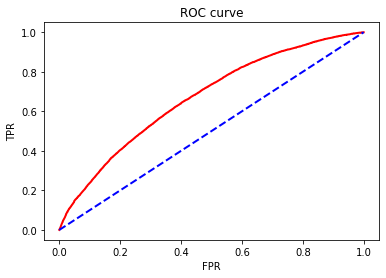

In [48]:
fpr, tpr,_=roc_curve(Y_test,probs,pos_label = 1)

plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [49]:
roc_auc_score(Y_test, probs)

0.6697221783960844

In [50]:
# log loss
log_loss(Y_test, LR.predict_proba(X_test))

0.444098713750873

In [51]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 0.18035034475414638
Mean Squared Error: 0.18035034475414638
Root Mean Squared Error: 0.42467675325374993


In [52]:
output_summary = pd.DataFrame(X_test.C18_2)
output_summary['click'] = Y_test.copy().values
output_summary['log_base'] = probs

In [53]:
output_summary.head()

,C18_2,click,log_base
0,-1.0,0,0.188416
1,-1.0,0,0.231973
2,1.0,1,0.468357
3,-1.0,0,0.235360
4,1.0,0,0.178628


# 2.b. Logistic + Naive Post Processing

In [54]:
output_summary.groupby('C18_2').log_base.mean()

C18_2
-1.0    0.152427
 1.0    0.297020
Name: log_base, dtype: float64

In [55]:
lo = output_summary.loc[output_summary.C18_2 == -1].log_base.mean()
hi = output_summary.loc[output_summary.C18_2 == 1].log_base.mean()
print(lo / hi)

0.5131857414069658


In [56]:
output_summary['log_naive'] = output_summary.log_base.values
output_summary.loc[output_summary.C18_2 == 1, 'log_naive'] = output_summary.log_naive * lo / hi

In [57]:
output_summary.groupby('C18_2').log_naive.mean()

C18_2
-1.0    0.152427
 1.0    0.152427
Name: log_naive, dtype: float64

In [58]:
output_summary.head()

,C18_2,click,log_base,log_naive
0,-1.0,0,0.188416,0.188416
1,-1.0,0,0.231973,0.231973
2,1.0,1,0.468357,0.240354
3,-1.0,0,0.235360,0.235360
4,1.0,0,0.178628,0.091670


# 2.c. Logistic + FPCA

In [59]:
LR = LogisticRegression(solver = 'saga', penalty ='l2', max_iter=150)
LR.fit(X_train_fpca, Y_train)

/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
y_pred_fpca = LR.predict(X_test_fpca)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LR.score(X_test_fpca, Y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [61]:
probs_fpca = LR.predict_proba(X_test_fpca)
probs_fpca = probs_fpca[:, 1]

In [62]:
cm = confusion_matrix(Y_test, y_pred_fpca)
print(cm)

[[61430   183]
 [13401   112]]


In [63]:
print(classification_report(Y_test, y_pred_fpca))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     61613
           1       0.38      0.01      0.02     13513

    accuracy                           0.82     75126
   macro avg       0.60      0.50      0.46     75126
weighted avg       0.74      0.82      0.74     75126



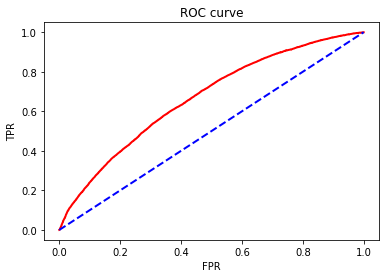

In [64]:
fpr, tpr,_=roc_curve(Y_test, probs_fpca, pos_label = 1)

import matplotlib.pyplot as plt
plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [65]:
roc_auc_score(Y_test, probs_fpca)

0.6667932246112999

In [66]:
# log loss
log_loss(Y_test, LR.predict_proba(X_test_fpca))

0.445157573596222

In [67]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_fpca))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_fpca))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_fpca)))

Mean Absolute Error: 0.18081622873572398
Mean Squared Error: 0.18081622873572398
Root Mean Squared Error: 0.4252249154691244


In [68]:
output_summary['log_fpca'] = probs_fpca

In [69]:
output_summary.head()

,C18_2,click,log_base,log_naive,log_fpca
0,-1.0,0,0.188416,0.188416,0.187844
1,-1.0,0,0.231973,0.231973,0.254367
2,1.0,1,0.468357,0.240354,0.449673
3,-1.0,0,0.235360,0.235360,0.247900
4,1.0,0,0.178628,0.091670,0.139546


In [70]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca
C18_2,,,,
-1.0,0.153428,0.152427,0.152427,0.161133
1.0,0.293022,0.297020,0.152427,0.259766


# 3.a. Random Forest

In [71]:
rf = RandomForestClassifier(max_features = 20, class_weight = 'balanced')
rf.fit(X_train, Y_train)
predict = rf.predict(X_test)

In [72]:
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predict))
print("Classification Report")
print(classification_report(Y_test, predict))

Confusion Matrix:
[[53801  7812]
 [ 9970  3543]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     61613
           1       0.31      0.26      0.28     13513

    accuracy                           0.76     75126
   macro avg       0.58      0.57      0.57     75126
weighted avg       0.75      0.76      0.76     75126



In [73]:
probs = rf.predict_proba(X_test)
probs = probs[:, 1]

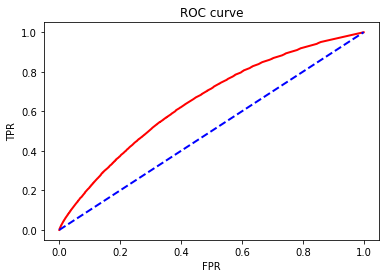

In [74]:
fpr, tpr,_=roc_curve(Y_test, probs, pos_label = 1)
plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [75]:
roc_auc_score(Y_test, probs)

0.6514438771629515

In [76]:
log_loss(Y_test, rf.predict_proba(X_test))

0.8067754707033741

In [77]:
output_summary['rf_base'] = probs

In [78]:
output_summary.head()

,C18_2,click,log_base,log_naive,log_fpca,rf_base
0,-1.0,0,0.188416,0.188416,0.187844,0.130000
1,-1.0,0,0.231973,0.231973,0.254367,0.570000
2,1.0,1,0.468357,0.240354,0.449673,0.010000
3,-1.0,0,0.235360,0.235360,0.247900,0.421565
4,1.0,0,0.178628,0.091670,0.139546,0.140000


In [79]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base
C18_2,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805
1.0,0.293022,0.297020,0.152427,0.259766,0.357133


# 3.b. Random Forest + Naive Post Processing

In [80]:
lo = output_summary.loc[output_summary.C18_2 == -1].rf_base.mean()
hi = output_summary.loc[output_summary.C18_2 == 1].rf_base.mean()
print(lo / hi)

0.5174682652484369


In [81]:
output_summary['rf_naive'] = output_summary.rf_base.values
output_summary.loc[output_summary.C18_2 == 1, 'rf_naive'] = output_summary.rf_naive * lo / hi

In [82]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base,rf_naive
C18_2,,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805,0.184805
1.0,0.293022,0.297020,0.152427,0.259766,0.357133,0.184805


# 3.c. Random Forest + FPCA

In [83]:
rf = RandomForestClassifier(max_features = 2, class_weight = 'balanced')
rf.fit(X_train_fpca, Y_train)
predict = rf.predict(X_test_fpca)

In [84]:
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predict))
print("Classification Report")
print(classification_report(Y_test, predict))

Confusion Matrix:
[[53488  8125]
 [10056  3457]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     61613
           1       0.30      0.26      0.28     13513

    accuracy                           0.76     75126
   macro avg       0.57      0.56      0.57     75126
weighted avg       0.74      0.76      0.75     75126



In [85]:
probs_fpca = rf.predict_proba(X_test_fpca)
probs_fpca = probs_fpca[:, 1]

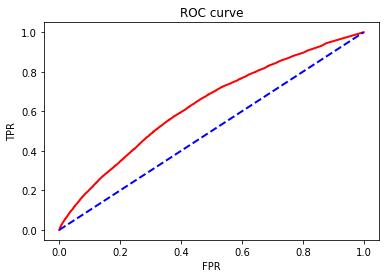

In [86]:
fpr, tpr,_=roc_curve(Y_test, probs_fpca, pos_label = 1)
plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [87]:
roc_auc_score(Y_test, probs_fpca)

0.6306164100825675

In [88]:
log_loss(Y_test, rf.predict_proba(X_test_fpca))

0.8603980686331623

In [89]:
output_summary['rf_fpca'] = probs_fpca

In [90]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base,rf_naive,rf_fpca
C18_2,,,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805,0.184805,0.184801
1.0,0.293022,0.297020,0.152427,0.259766,0.357133,0.184805,0.350111


# 4.a. Ada-Boosting

In [91]:
#lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

# max_features = % of max number of features

#for learning_rate in lr_list:
#    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, 
#                                        max_features=1.0, max_depth=200, random_state=0)
#    gb_clf.fit(X_train, Y_train)

#    print("Learning rate: ", learning_rate)
#    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
#    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, Y_test)))

In [92]:
# optimal learning rate = 1 from the cell above

gb = AdaBoostClassifier(n_estimators=20, learning_rate=1, random_state=0)
gb.fit(X_train, Y_train)
predict = gb.predict(X_test)

In [93]:
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predict))
print("Classification Report")
print(classification_report(Y_test, predict))

Confusion Matrix:
[[61394   219]
 [13279   234]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     61613
           1       0.52      0.02      0.03     13513

    accuracy                           0.82     75126
   macro avg       0.67      0.51      0.47     75126
weighted avg       0.77      0.82      0.74     75126



In [94]:
probs = gb.predict_proba(X_test)
probs = probs[:, 1]

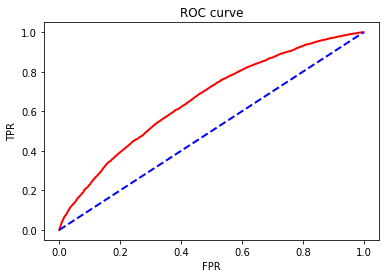

In [95]:
fpr, tpr,_=roc_curve(Y_test, probs, pos_label = 1)
plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [96]:
roc_auc_score(Y_test, probs)

0.6605507325477871

In [97]:
# log loss
log_loss(Y_test, gb.predict_proba(X_test))

0.6652206576173831

In [98]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, predict))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, predict)))

Mean Absolute Error: 0.17967148523813328
Mean Squared Error: 0.17967148523813328
Root Mean Squared Error: 0.4238767335418792


In [99]:
output_summary['boost_base'] = probs

In [100]:
output_summary.groupby('C18_2').boost_base.mean()

C18_2
-1.0    0.477166
 1.0    0.489766
Name: boost_base, dtype: float64

# 4.b. Ada-Boosting + Naive Post Processing

In [101]:
lo = output_summary.loc[output_summary.C18_2 == -1].boost_base.mean()
hi = output_summary.loc[output_summary.C18_2 == 1].boost_base.mean()
print(lo / hi)

0.97427426714873


In [102]:
output_summary['boost_naive'] = output_summary.boost_base.values
output_summary.loc[output_summary.C18_2 == 1, 'boost_naive'] = output_summary.boost_naive * lo / hi

In [103]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base,rf_naive,rf_fpca,boost_base,boost_naive
C18_2,,,,,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805,0.184805,0.184801,0.477166,0.477166
1.0,0.293022,0.297020,0.152427,0.259766,0.357133,0.184805,0.350111,0.489766,0.477166


# 4.c. Ada-Boosting + FPCA

In [104]:
gb = AdaBoostClassifier(n_estimators=20, learning_rate=1, random_state=0)
gb.fit(X_train_fpca, Y_train)
predict = gb.predict(X_test_fpca)

In [105]:
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predict))
print("Classification Report")
print(classification_report(Y_test, predict))

Confusion Matrix:
[[61329   284]
 [13268   245]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     61613
           1       0.46      0.02      0.03     13513

    accuracy                           0.82     75126
   macro avg       0.64      0.51      0.47     75126
weighted avg       0.76      0.82      0.74     75126



In [106]:
probs_fpca = gb.predict_proba(X_test_fpca)
probs_fpca = probs_fpca[:, 1]

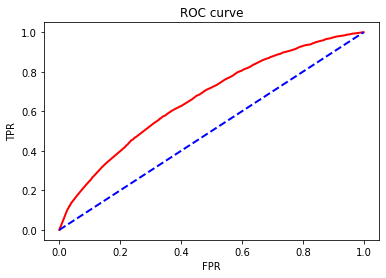

In [107]:
fpr, tpr,_=roc_curve(Y_test, probs_fpca, pos_label = 1)
plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [108]:
roc_auc_score(Y_test, probs_fpca)

0.6648782767844474

In [109]:
# log loss
log_loss(Y_test, gb.predict_proba(X_test_fpca))

0.665038756435083

In [110]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, predict))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, predict)))

Mean Absolute Error: 0.18039027766685303
Mean Squared Error: 0.18039027766685303
Root Mean Squared Error: 0.4247237663080005


In [111]:
output_summary['boost_fpca'] = probs_fpca

In [112]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base,rf_naive,rf_fpca,boost_base,boost_naive,boost_fpca
C18_2,,,,,,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805,0.184805,0.184801,0.477166,0.477166,0.477825
1.0,0.293022,0.297020,0.152427,0.259766,0.357133,0.184805,0.350111,0.489766,0.477166,0.486587


# 5.a. SVM

In [113]:
svm = LinearSVC(random_state=0, class_weight = 'balanced', max_iter = 1000)
clf = CalibratedClassifierCV(svm)
clf.fit(X_train, Y_train)

/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarni

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight='balanced',
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=0, tol=0.0001,
                                                verbose=0),
                       cv=None, method='sigmoid')

In [114]:
probs = clf.predict_proba(X_test)[:,1]

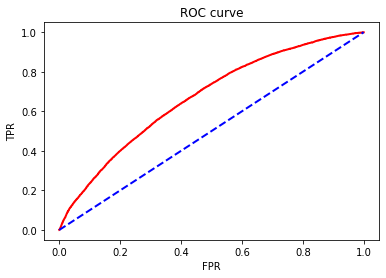

In [115]:
fpr, tpr,_=roc_curve(Y_test, probs, drop_intermediate=False)
plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [116]:
roc_auc_score(Y_test, probs)

0.6695697167247229

In [117]:
# log loss
log_loss(Y_test, probs)

0.444328122965805

In [118]:
output_summary['svm_base'] = probs

In [119]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base,rf_naive,rf_fpca,boost_base,boost_naive,boost_fpca,svm_base
C18_2,,,,,,,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805,0.184805,0.184801,0.477166,0.477166,0.477825,0.152402
1.0,0.293022,0.297020,0.152427,0.259766,0.357133,0.184805,0.350111,0.489766,0.477166,0.486587,0.296720


# 5.b. SVM + Naive Post Processing

In [120]:
lo = output_summary.loc[output_summary.C18_2 == -1].svm_base.mean()
hi = output_summary.loc[output_summary.C18_2 == 1].svm_base.mean()
print(lo / hi)

0.5136225156026106


In [121]:
output_summary['svm_naive'] = output_summary.svm_base.values
output_summary.loc[output_summary.C18_2 == 1, 'svm_naive'] = output_summary.svm_naive * lo / hi 

In [122]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base,rf_naive,rf_fpca,boost_base,boost_naive,boost_fpca,svm_base,svm_naive
C18_2,,,,,,,,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805,0.184805,0.184801,0.477166,0.477166,0.477825,0.152402,0.152402
1.0,0.293022,0.297020,0.152427,0.259766,0.357133,0.184805,0.350111,0.489766,0.477166,0.486587,0.296720,0.152402


# 5.c. SVM + FPCA

In [123]:
svm = LinearSVC(random_state=0, class_weight = 'balanced', max_iter = 1000)
clf = CalibratedClassifierCV(svm)
clf.fit(X_train_fpca, Y_train)

/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarni

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight='balanced',
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=0, tol=0.0001,
                                                verbose=0),
                       cv=None, method='sigmoid')

In [124]:
probs_fpca = clf.predict_proba(X_test_fpca)[:,1]

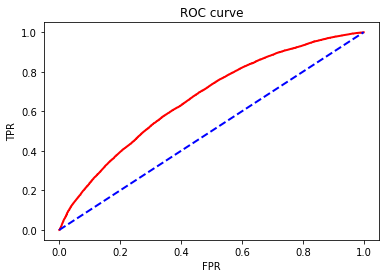

In [125]:
fpr, tpr,_=roc_curve(Y_test, probs_fpca, drop_intermediate=False)
plt.figure()

##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [126]:
roc_auc_score(Y_test, probs_fpca)

0.6667710764955573

In [127]:
# log loss
log_loss(Y_test, probs_fpca)

0.44525132824339314

In [128]:
output_summary['svm_fpca'] = probs_fpca

In [129]:
output_summary.groupby('C18_2').mean()

,click,log_base,log_naive,log_fpca,rf_base,rf_naive,rf_fpca,boost_base,boost_naive,boost_fpca,svm_base,svm_naive,svm_fpca
C18_2,,,,,,,,,,,,,
-1.0,0.153428,0.152427,0.152427,0.161133,0.184805,0.184805,0.184801,0.477166,0.477166,0.477825,0.152402,0.152402,0.161712
1.0,0.293022,0.297020,0.152427,0.259766,0.357133,0.184805,0.350111,0.489766,0.477166,0.486587,0.296720,0.152402,0.257134


# 6. Result Summary

In [130]:
auc = [-99]

for i in range(2, output_summary.shape[1]):
    auc.append(roc_auc_score(output_summary.iloc[:,1], output_summary.iloc[:,i]))

In [131]:
ll = [-99]

for i in range(2, output_summary.shape[1]):
    ll.append(log_loss(output_summary.iloc[:,1], output_summary.iloc[:,i]))

In [132]:
metrics = pd.DataFrame(output_summary.groupby('C18_2').mean().transpose())

In [133]:
metrics['independence'] = (metrics.iloc[:,0] - metrics.iloc[:,1]).abs()

In [134]:
metrics['auc'] = auc

In [135]:
metrics['log_loss'] = ll

In [136]:
metrics

C18_2,-1.0,1.0,independence,auc,log_loss
click,0.153428,0.293022,1.395942e-01,-99.000000,-99.000000
log_base,0.152427,0.297020,1.445937e-01,0.669722,0.444099
log_naive,0.152427,0.152427,1.748601e-15,0.639650,0.456437
log_fpca,0.161133,0.259766,9.863318e-02,0.666793,0.445158
rf_base,0.184805,0.357133,1.723282e-01,0.651444,0.806776
rf_naive,0.184805,0.184805,8.604228e-16,0.635840,0.798095
rf_fpca,0.184801,0.350111,1.653093e-01,0.630616,0.860398
boost_base,0.477166,0.489766,1.259958e-02,0.660551,0.665221
boost_naive,0.477166,0.477166,1.171285e-14,0.624428,0.663407
boost_fpca,0.477825,0.486587,8.762067e-03,0.664878,0.665039


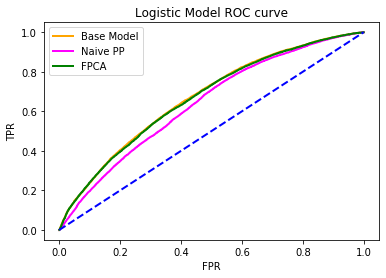

In [137]:
fpr_b, tpr_b,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,2], drop_intermediate=False)
fpr_n, tpr_n,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,3], drop_intermediate=False)
fpr_f, tpr_f,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,4], drop_intermediate=False)
plt.figure()

##Adding the ROC
plt.plot(fpr_b, tpr_b, color='orange', lw=2, label='Base Model')
plt.plot(fpr_n, tpr_n, color='magenta', lw=2, label='Naive PP')
plt.plot(fpr_f, tpr_f, color='green', lw=2, label='FPCA')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Model ROC curve')
plt.legend()
plt.show()

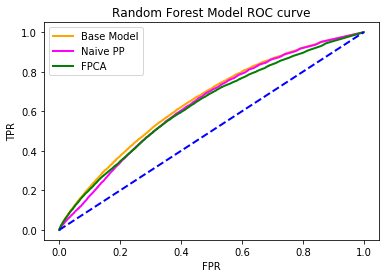

In [138]:
fpr_b, tpr_b,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,5], drop_intermediate=False)
fpr_n, tpr_n,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,6], drop_intermediate=False)
fpr_f, tpr_f,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,7], drop_intermediate=False)
plt.figure()

##Adding the ROC
plt.plot(fpr_b, tpr_b, color='orange', lw=2, label='Base Model')
plt.plot(fpr_n, tpr_n, color='magenta', lw=2, label='Naive PP')
plt.plot(fpr_f, tpr_f, color='green', lw=2, label='FPCA')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest Model ROC curve')
plt.legend()
plt.show()

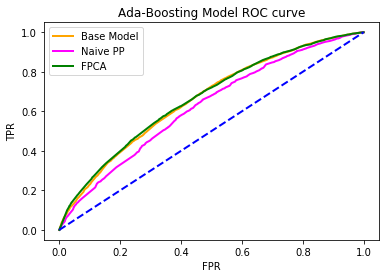

In [139]:
fpr_b, tpr_b,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,8], drop_intermediate=False)
fpr_n, tpr_n,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,9], drop_intermediate=False)
fpr_f, tpr_f,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,10], drop_intermediate=False)
plt.figure()

##Adding the ROC
plt.plot(fpr_b, tpr_b, color='orange', lw=2, label='Base Model')
plt.plot(fpr_n, tpr_n, color='magenta', lw=2, label='Naive PP')
plt.plot(fpr_f, tpr_f, color='green', lw=2, label='FPCA')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Ada-Boosting Model ROC curve')
plt.legend()
plt.show()

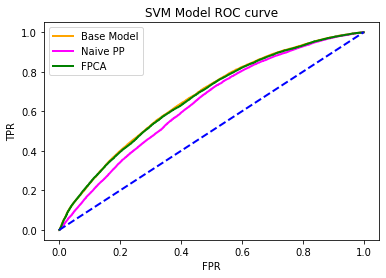

In [140]:
fpr_b, tpr_b,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,11], drop_intermediate=False)
fpr_n, tpr_n,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,12], drop_intermediate=False)
fpr_f, tpr_f,_=roc_curve(output_summary.iloc[:,1], output_summary.iloc[:,13], drop_intermediate=False)
plt.figure()

##Adding the ROC
plt.plot(fpr_b, tpr_b, color='orange', lw=2, label='Base Model')
plt.plot(fpr_n, tpr_n, color='magenta', lw=2, label='Naive PP')
plt.plot(fpr_f, tpr_f, color='green', lw=2, label='FPCA')

##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('SVM Model ROC curve')
plt.legend()
plt.show()

In [158]:
for i in range(2, 14):
    print(output_summary.iloc[:,i].describe())

count    75126.000000
mean         0.179817
std          0.091774
min          0.003798
25%          0.107845
50%          0.172161
75%          0.223280
max          0.881962
Name: log_base, dtype: float64
count    75126.000000
mean         0.152427
std          0.063281
min          0.003798
25%          0.101583
50%          0.150899
75%          0.195942
max          0.881962
Name: log_naive, dtype: float64
count    75126.000000
mean         0.179817
std          0.089096
min          0.005563
25%          0.109917
50%          0.174337
75%          0.229679
max          0.937928
Name: log_fpca, dtype: float64
count    75126.000000
mean         0.217449
std          0.234307
min          0.000000
25%          0.030000
50%          0.129014
75%          0.344438
max          1.000000
Name: rf_base, dtype: float64
count    75126.000000
mean         0.184805
std          0.201531
min          0.000000
25%          0.028818
50%          0.110000
75%          0.284086
max          1.000

Text(0, 0.5, 'Density')

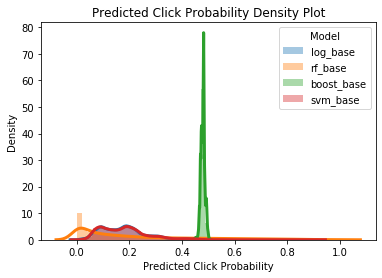

In [178]:
for i in [2, 5, 8, 11]:
    # Draw the density plot
    sns.distplot(output_summary.iloc[:,i], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = output_summary.columns[i])
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Model')
plt.title('Predicted Click Probability Density Plot')
plt.xlabel('Predicted Click Probability')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

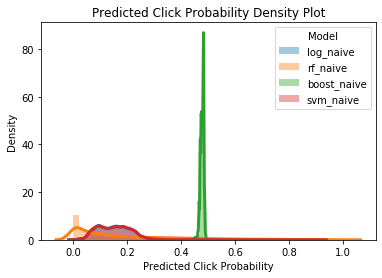

In [179]:
for i in [3, 6, 9, 12]:
    # Draw the density plot
    sns.distplot(output_summary.iloc[:,i], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = output_summary.columns[i])
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Model')
plt.title('Predicted Click Probability Density Plot')
plt.xlabel('Predicted Click Probability')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

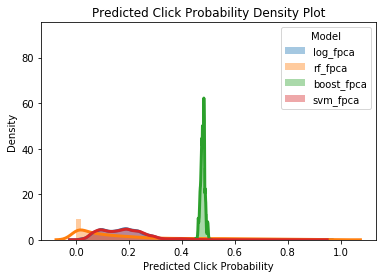

In [180]:
for i in [4, 7, 10, 13]:
    # Draw the density plot
    sns.distplot(output_summary.iloc[:,i], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = output_summary.columns[i])
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Model')
plt.title('Predicted Click Probability Density Plot')
plt.xlabel('Predicted Click Probability')
plt.ylabel('Density')

# 7. FPCA Dimension Reduction

In [215]:
fpca_dim = output_summary.iloc[:, [0, 1, 2, 3]]
fpca_dim.head()

,C18_2,click,log_base,log_naive
0,-1.0,0,0.188416,0.188416
1,-1.0,0,0.231973,0.231973
2,1.0,1,0.468357,0.240354
3,-1.0,0,0.235360,0.235360
4,1.0,0,0.178628,0.091670


In [216]:
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45]:

    # PCA
    pca = PCA(n_components = i)
    X_train_pc = pd.DataFrame(pca.fit_transform(X_train_fpca))
    X_test_pc = pd.DataFrame(pca.transform(X_test_fpca))

    # Log Regression
    LR = LogisticRegression(solver = 'saga', penalty ='l2', max_iter=150)
    LR.fit(X_train_pc, Y_train)
    
    # Prediction
    probs_pc = LR.predict_proba(X_test_pc)
    probs_pc = probs_pc[:, 1]
    
    fpca_dim['pc'+str(i)] = probs_pc

/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/howard.zheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [217]:
fpca_dim['full_rank'] = output_summary.log_fpca.values

fpca_dim.head()

,C18_2,click,log_base,log_naive,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc15,pc20,pc25,pc30,pc35,pc40,pc45,full_rank
0,-1.0,0,0.188416,0.188416,0.208024,0.217321,0.218003,0.206160,0.154248,0.162712,0.160336,0.133501,0.118911,0.123084,0.114898,0.096660,0.129269,0.134077,0.164102,0.185109,0.187844
1,-1.0,0,0.231973,0.231973,0.129616,0.132909,0.149104,0.158462,0.226491,0.218358,0.262300,0.269779,0.230173,0.198483,0.233073,0.247837,0.252573,0.260218,0.258438,0.259998,0.254367
2,1.0,1,0.468357,0.240354,0.233962,0.272075,0.271113,0.269696,0.343083,0.339185,0.369692,0.387072,0.406262,0.455755,0.488215,0.469248,0.470746,0.452580,0.454453,0.464750,0.449673
3,-1.0,0,0.235360,0.235360,0.204482,0.206924,0.206435,0.209794,0.230419,0.226580,0.222315,0.213799,0.226236,0.239986,0.256053,0.265262,0.263639,0.258268,0.255179,0.250961,0.247900
4,1.0,0,0.178628,0.091670,0.185965,0.200474,0.200577,0.214226,0.223240,0.215834,0.224690,0.200958,0.213595,0.202392,0.208900,0.216842,0.172212,0.129538,0.126382,0.130610,0.139546


In [218]:
ll = [-99]

for i in range(2, fpca_dim.shape[1]):
    ll.append(log_loss(fpca_dim.iloc[:,1], fpca_dim.iloc[:,i]))

ll

[-99,
 0.444098713750873,
 0.45643708001177674,
 0.4659996445990939,
 0.4656547008025312,
 0.4655272826897934,
 0.46359944130597486,
 0.4587527706116635,
 0.45874354081345203,
 0.4573353236884204,
 0.4553382050500859,
 0.4548648441013214,
 0.4530187055162225,
 0.451564218923256,
 0.45063892571202574,
 0.45026632591549337,
 0.4475633494054579,
 0.4468523615845066,
 0.4461535984930671,
 0.445157573596222]

In [219]:
auc = [-99]

for i in range(2, fpca_dim.shape[1]):
    auc.append(roc_auc_score(fpca_dim.iloc[:,1], fpca_dim.iloc[:,i]))

auc

[-99,
 0.6697221783960844,
 0.6396496986512838,
 0.5765875945023855,
 0.5659475231938125,
 0.5666115991322834,
 0.5771157982366661,
 0.6130499041283858,
 0.6120042884613401,
 0.6176135017575184,
 0.6228368453925162,
 0.6244109506534709,
 0.6339874992311367,
 0.6401265929844576,
 0.6433651771871058,
 0.6456446711082824,
 0.6580429196588308,
 0.6606356520748606,
 0.663216773545398,
 0.6667932246112999]

In [220]:
fpca_dim_summary = pd.DataFrame(fpca_dim.groupby('C18_2').mean().transpose())
fpca_dim_summary['independence'] = (fpca_dim_summary.iloc[:,0] - fpca_dim_summary.iloc[:,1]).abs()
fpca_dim_summary

C18_2,-1.0,1.0,independence
click,0.153428,0.293022,1.395942e-01
log_base,0.152427,0.297020,1.445937e-01
log_naive,0.152427,0.152427,1.748601e-15
pc2,0.176640,0.192889,1.624917e-02
pc3,0.176304,0.194579,1.827567e-02
pc4,0.176488,0.193751,1.726304e-02
pc5,0.173909,0.204664,3.075452e-02
pc6,0.168875,0.226900,5.802444e-02
pc7,0.169302,0.225120,5.581761e-02
pc8,0.167833,0.231396,6.356271e-02


In [221]:
fpca_dim_summary['auc'] = auc
fpca_dim_summary['log_loss'] = ll

In [222]:
fpca_dim_summary

C18_2,-1.0,1.0,independence,auc,log_loss
click,0.153428,0.293022,1.395942e-01,-99.000000,-99.000000
log_base,0.152427,0.297020,1.445937e-01,0.669722,0.444099
log_naive,0.152427,0.152427,1.748601e-15,0.639650,0.456437
pc2,0.176640,0.192889,1.624917e-02,0.576588,0.466000
pc3,0.176304,0.194579,1.827567e-02,0.565948,0.465655
pc4,0.176488,0.193751,1.726304e-02,0.566612,0.465527
pc5,0.173909,0.204664,3.075452e-02,0.577116,0.463599
pc6,0.168875,0.226900,5.802444e-02,0.613050,0.458753
pc7,0.169302,0.225120,5.581761e-02,0.612004,0.458744
pc8,0.167833,0.231396,6.356271e-02,0.617614,0.457335
